<a href="https://colab.research.google.com/github/Harry1226/Arduino_project/blob/main/0619-1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow==2.1.1-rc1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement tensorflow==2.1.1-rc1 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==2.1.1-rc1


In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

SEED = 1134
np.random.seed(SEED)
tf.random.set_seed(SEED)

#define the name of th gestures
#(need to be the same name with the file. name.csv)

GESTURES = [
            #"stepping_1",
            #"stepping_2",
            "walking",
            "standing",
            "squat",
            ]

SAMPLES_PER_GESTURE = 60

NUM_GESTURES = len(GESTURES)
#print(NUM_GESTURES)

ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)
#print(ONE_HOT_ENCODED_GESTURES)

inputs = []
outputs = []

TensorFlow version = 2.12.0



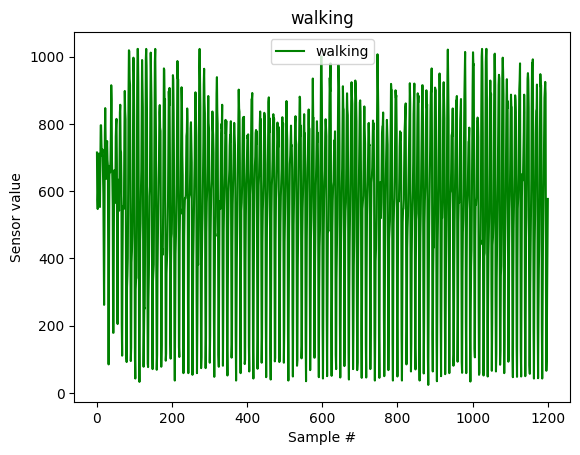

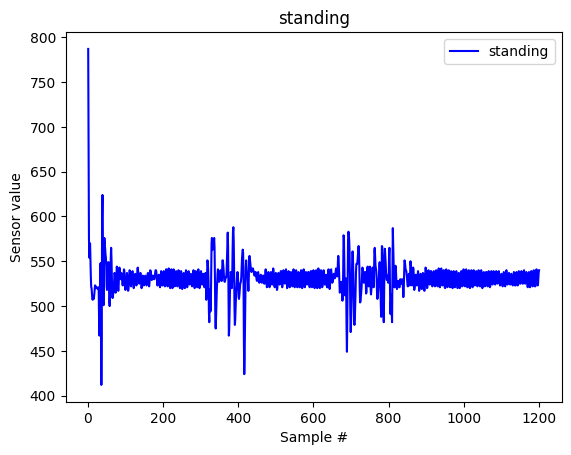

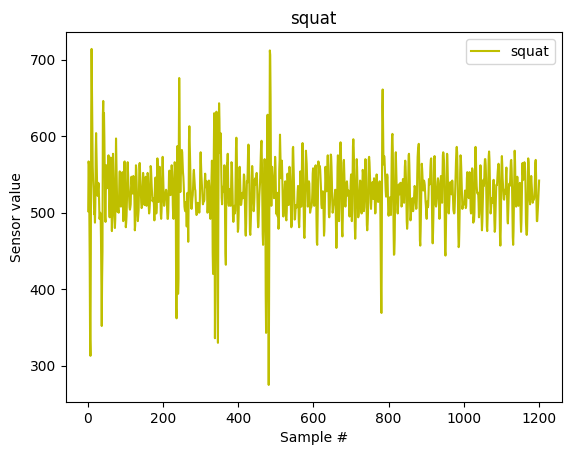

In [65]:
#plotting the data
clrs = ['g', 'b', 'y', 'c']
for i in range(NUM_GESTURES):
  df = pd.read_csv("/content/" + GESTURES[i] + ".csv")
  index = range(1, len(df['value']) + 1)

  plt.plot(index, df['value'],label = GESTURES[i], color = clrs[i])
  plt.title(GESTURES[i])
  plt.xlabel("Sample #")
  plt.ylabel("Sensor value")
  plt.legend()
  plt.show()

In [66]:
for i in range(NUM_GESTURES):
  df = pd.read_csv("/content/" + GESTURES[i] + ".csv")

  cur_max = df['value'].max()
  cur_min = df['value'].min()

  if i > 0:
    if cur_max > max:
      max = cur_max
    if cur_min < min:
      min = cur_min
  else:
    max = cur_max
    min = cur_min

print("maximum:")
print(max)
print("minimum")
print(min)

for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")

  output = ONE_HOT_ENCODED_GESTURES[gesture_index]

  df = pd.read_csv("/content/" + gesture + ".csv")

  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")


  #normalize the input data
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE):
      index = i * SAMPLES_PER_GESTURE + j
      tensor += [
         (df['value'][index] - min) / (max - min)
      ]

    inputs.append(tensor)
    outputs.append(output)

inputs = np.array(inputs)
outputs = np.array(outputs)

print(inputs.shape)
#print(outputs)


print("Data set parsing and preparation complete.")


maximum:
1023
minimum
24
Processing index 0 for gesture 'walking'.
	There are 20 recordings of the walking gesture.
Processing index 1 for gesture 'standing'.
	There are 20 recordings of the standing gesture.
Processing index 2 for gesture 'squat'.
	There are 20 recordings of the squat gesture.
(60, 60)
Data set parsing and preparation complete.


In [85]:
num_inputs = len(inputs)

randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

inputs = inputs[randomize]
outputs = outputs[randomize]

TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs)+TRAIN_SPLIT

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

#inputs_train, inputs_test, inputs_validate = np.split(inputs, [6,2])
#outputs_train, outputs_test, outputs_validate = np.split(outputs, [6,2])

#Reshaping inputs and outputs before feeding to the model
inputs_train = inputs_train.reshape(TRAIN_SPLIT, 1, SAMPLES_PER_GESTURE, 1)
inputs_validate = inputs_validate.reshape(TEST_SPLIT-TRAIN_SPLIT, 1, SAMPLES_PER_GESTURE, 1)
inputs_test = inputs_test.reshape(TEST_SPLIT-TRAIN_SPLIT, 1, SAMPLES_PER_GESTURE, 1)
outputs_train = outputs_train.reshape(TRAIN_SPLIT,NUM_GESTURES)
outputs_validate = outputs_validate.reshape(TEST_SPLIT-TRAIN_SPLIT,NUM_GESTURES)
outputs_test = outputs_test.reshape(TEST_SPLIT-TRAIN_SPLIT,NUM_GESTURES)

print(inputs_train.shape)
print(inputs_validate.shape)

print("Data set randomization and splitting complete.")

(36, 1, 60, 1)
(12, 1, 60, 1)
Data set randomization and splitting complete.


In [113]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, LSTM, Activation
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D


model = Sequential()
model.add(Conv2D(
                 filters=8, #the number of filters (using #num different kind of filters)
                 kernel_size=(1,6), #the size of kernel
                 activation = 'relu',
                 input_shape= (1,SAMPLES_PER_GESTURE,1)
                 ))
model.add(MaxPooling2D(pool_size = (1,3)))
model.add(Flatten())
model.add(Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(
              optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy'
              )

model.summary()



Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 1, 55, 8)          56        
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 1, 18, 8)         0         
 2D)                                                             
                                                                 
 flatten_19 (Flatten)        (None, 144)               0         
                                                                 
 dense_27 (Dense)            (None, 3)                 435       
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [114]:
history = model.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))

Epoch 1/400
9/9 [==============================] - 1s 30ms/step - loss: 1.1293 - accuracy: 0.4167 - val_loss: 1.1074 - val_accuracy: 0.2500
Epoch 2/400
9/9 [==============================] - 0s 8ms/step - loss: 1.1036 - accuracy: 0.4167 - val_loss: 1.1216 - val_accuracy: 0.2500
Epoch 3/400
9/9 [==============================] - 0s 6ms/step - loss: 1.0852 - accuracy: 0.4167 - val_loss: 1.1191 - val_accuracy: 0.2500
Epoch 4/400
9/9 [==============================] - 0s 10ms/step - loss: 1.0831 - accuracy: 0.4167 - val_loss: 1.1242 - val_accuracy: 0.3333
Epoch 5/400
9/9 [==============================] - 0s 8ms/step - loss: 1.0722 - accuracy: 0.4444 - val_loss: 1.1172 - val_accuracy: 0.3333
Epoch 6/400
9/9 [==============================] - 0s 8ms/step - loss: 1.0666 - accuracy: 0.4444 - val_loss: 1.1091 - val_accuracy: 0.5833
Epoch 7/400
9/9 [==============================] - 0s 6ms/step - loss: 1.0609 - accuracy: 0.6389 - val_loss: 1.0997 - val_accuracy: 0.5833
Epoch 8/400
9/9 [========

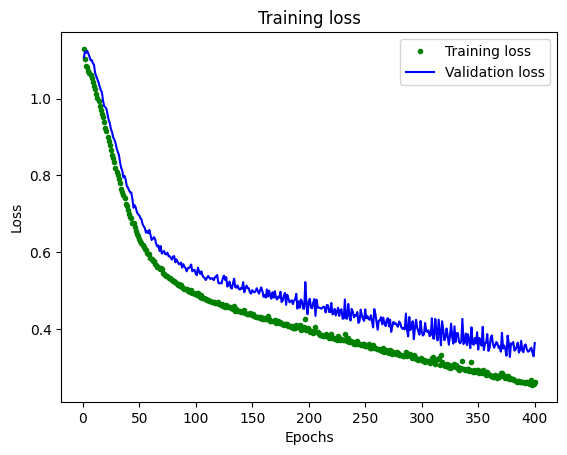

[6.4, 4.8]


In [115]:
# increase the size of the graphs. The default size is (6,4).
#plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b-', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

In [116]:
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs

print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data


1/1 [==============================] - 0s 65ms/step
predictions =
 [[0.009 0.264 0.727]
 [1.    0.    0.   ]
 [0.001 0.823 0.176]
 [0.043 0.316 0.641]
 [0.005 0.438 0.557]
 [0.009 0.577 0.414]
 [0.986 0.    0.014]
 [0.998 0.    0.002]
 [0.016 0.352 0.633]
 [0.997 0.    0.003]
 [0.001 0.807 0.192]
 [0.999 0.    0.001]]
actual =
 [[0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]]


In [117]:
test_loss, test_acc = model.evaluate(inputs_test, outputs_test)

1/1 [==============================] - 0s 160ms/step - loss: 0.2600 - accuracy: 0.9167


In [118]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

Model is 4360 bytes


In [119]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 26,922 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
